In [1]:
from glob import glob
import malaya_speech
import random
import numpy as np
from datasets import Audio
import os

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [2]:
files = random.sample(glob('/home/husein/ssd2/LibriSpeech/*/*/*/*.flac'), 10000)
edge_tts = random.sample(glob('/home/husein/ssd2/*-tts-wav/*.wav'), 10000)
wavenet = random.sample(glob('/home/husein/ssd2/ms-MY-Wavenet-*/*.mp3'), 10000)
musan_speech = glob('/home/husein/ssd2/noise/musan/speech/*/*')
vctk = random.sample(glob('/home/husein/ssd2/wav48_silence_trimmed/*/*.flac'), 10000)

audio = files + edge_tts + wavenet + musan_speech + vctk
random.shuffle(audio)

In [3]:
mic_noise = glob('/home/husein/ssd2/noise/mic-noise/*')
non_speech = glob('/home/husein/ssd2/noise/Nonspeech/*')
musan_noise = glob('/home/husein/ssd2/noise/musan/noise/*/*.wav')
musan_music = glob('/home/husein/ssd2/noise/musan/music/*/*.wav')
noises = mic_noise + non_speech + musan_noise + musan_music
noises = [f for f in noises if os.path.getsize(f) / 1e6 < 10]
random.shuffle(noises)

In [4]:
sr = 16000
audio = Audio(sampling_rate=sr)

In [5]:
%%time

y = audio.decode_example(audio.encode_example(vctk[0]))['array']
y = malaya_speech.augmentation.waveform.random_pitch(y)
noise = audio.decode_example(audio.encode_example(random.choice(noises)))['array']
y_noise = malaya_speech.augmentation.waveform.add_noise(y, noise, factor = random.uniform(0.3, 0.7))

CPU times: user 257 ms, sys: 13.1 ms, total: 270 ms
Wall time: 286 ms


In [6]:
y_int = malaya_speech.astype.float_to_int(y)
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.3)))
frames_int = malaya_speech.generator.frames(y_int, 30, sr, False)
frames = malaya_speech.generator.frames(y, 30, sr, False)
frames_noise = malaya_speech.generator.frames(y_noise, 30, sr, False)
frames = [(frames[no], vad(frame)) for no, frame in enumerate(frames_int)]
frames_noise = [(frames_noise[no], vad(frame)) for no, frame in enumerate(frames_int)]
grouped = malaya_speech.group.group_frames(frames)
grouped_noise = malaya_speech.group.group_frames(frames_noise)

In [7]:
grouped[0]

(<malaya_speech.model.frame.Frame at 0x7efd217c06d0>, False)

In [8]:
frame_size = 30

In [9]:
results = []
for k in range(len(grouped)):
    fs = malaya_speech.generator.frames(grouped[k][0], frame_size, sr, False)
    for fs_ in fs:
        results.append((fs_.array, int(grouped[k][1])))
    
    fs = malaya_speech.generator.frames(grouped_noise[k][0], frame_size, sr, False)
    for fs_ in fs:
        results.append((fs_.array, 0))
        
random.shuffle(results)

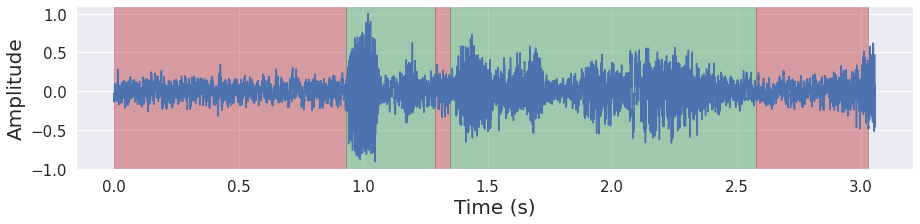

In [10]:
malaya_speech.extra.visualization.visualize_vad(y_noise, grouped_noise, sr)

In [11]:
import torch
from collections import namedtuple

Batch = namedtuple("Batch", ["features", 'features_length', "targets"])

class Dataset(torch.utils.data.IterableDataset):
    
    sr = 16000
    
    def __init__(self):
        super(Dataset).__init__()
        
        files = random.sample(glob('/home/husein/ssd2/LibriSpeech/*/*/*/*.flac'), 10000)
        edge_tts = random.sample(glob('/home/husein/ssd2/*-tts-wav/*.wav'), 10000)
        wavenet = random.sample(glob('/home/husein/ssd2/ms-MY-Wavenet-*/*.mp3'), 10000)
        musan_speech = glob('/home/husein/ssd2/noise/musan/speech/*/*')
        vctk = random.sample(glob('/home/husein/ssd2/wav48_silence_trimmed/*/*.flac'), 10000)

        speeches = files + edge_tts + wavenet + musan_speech + vctk
        random.shuffle(speeches)
        self.speeches = speeches
        
        mic_noise = glob('/home/husein/ssd2/noise/mic-noise/*')
        non_speech = glob('/home/husein/ssd2/noise/Nonspeech/*')
        musan_noise = glob('/home/husein/ssd2/noise/musan/noise/*/*.wav')
        musan_music = glob('/home/husein/ssd2/noise/musan/music/*/*.wav')
        noises = mic_noise + non_speech + musan_noise + musan_music
        noises = [f for f in noises if os.path.getsize(f) / 1e6 < 10]
        random.shuffle(noises)
        self.noises = noises
        
        self.audio = Audio(sampling_rate=sr)
        
        self.frame_sizes = [30, 50, 63]
    
    def __iter__(self):
        while True:
            for i in range(len(self.speeches)):
                f = self.speeches[i]
                y = self.audio.decode_example(self.audio.encode_example(f))['array']
                y = malaya_speech.augmentation.waveform.random_pitch(y)
                noise = self.audio.decode_example(self.audio.encode_example(random.choice(noises)))['array']
                y_noise = malaya_speech.augmentation.waveform.add_noise(y, noise, factor = random.uniform(0.3, 0.7))
                
                y_int = malaya_speech.astype.float_to_int(y)
                vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y_int), 0.3)))
                frames_int = malaya_speech.generator.frames(y_int, 30, sr, False)
                frames = malaya_speech.generator.frames(y, 30, sr, False)
                frames_noise = malaya_speech.generator.frames(y_noise, 30, sr, False)
                frames = [(frames[no], vad(frame)) for no, frame in enumerate(frames_int)]
                frames_noise = [(frames_noise[no], vad(frame)) for no, frame in enumerate(frames_int)]
                grouped = malaya_speech.group.group_frames(frames)
                grouped_noise = malaya_speech.group.group_frames(frames_noise)
                
                frame_size = random.choice(self.frame_sizes)
                print(frame_size)
                
                results = []
                for k in range(len(grouped)):
                    fs = malaya_speech.generator.frames(grouped[k][0], frame_size, sr, False)
                    for fs_ in fs:
                        results.append((fs_.array, int(grouped[k][1])))

                    fs = malaya_speech.generator.frames(grouped_noise[k][0], frame_size, sr, False)
                    for fs_ in fs:
                        results.append((fs_.array, 0))

                random.shuffle(results)
                
                for r in results:
                    yield torch.tensor(r[0], dtype = torch.float32), r[1]
        
dataset = Dataset()
# dataset = iter(dataset) 

In [12]:
def batch(batches):
    
    features = torch.nn.utils.rnn.pad_sequence([b[0] for b in batches], batch_first=True)
    features_length = torch.tensor([len(b[0]) for b in batches], dtype = torch.int32)
    targets = torch.tensor([b[1] for b in batches], dtype = torch.int64)
    return Batch(features, features_length, targets)

loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn = batch)
loader = iter(loader)

In [13]:
b = next(loader)

63


In [15]:
b.features

tensor([[-2.2926e-01, -2.3898e-01, -2.2758e-01,  ..., -7.4500e-02,
         -6.1319e-02, -5.1111e-02],
        [ 6.6782e-05,  8.1533e-05,  1.0465e-04,  ...,  1.2201e-05,
          5.8286e-05,  4.5007e-05],
        [-8.2483e-02, -7.3565e-02, -6.7966e-02,  ..., -5.3831e-02,
         -5.4532e-02, -5.4480e-02],
        [ 4.7355e-02,  5.4531e-02,  3.7061e-02,  ..., -3.8125e-02,
         -2.9255e-02, -2.1110e-02]])

In [15]:
import yaml
from malaya_speech.utils import nemo_featurization
from malaya_speech.nemo import conv_asr
import malaya_speech
from malaya_speech.utils.padding import sequence_1d
from malaya_boilerplate.torch_utils import to_tensor_cuda, to_numpy
import numpy as np
import torch

config = 'model_config.yaml'
with open(config) as stream:
    try:
        d = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        raise ValueError('invalid yaml')
    
d['decoder']['num_classes'] = 2
d['decoder']['angular'] = False

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        config = 'model_config.yaml'
        with open(config) as stream:
            try:
                d = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                raise ValueError('invalid yaml')

        d['decoder']['num_classes'] = 2
        d['decoder']['angular'] = False

        preprocessor = d['preprocessor'].copy()
        preprocessor_target = (preprocessor.pop('_target_', None) or preprocessor.pop('cls', None)).split('.')[-1]
        if 'params' in preprocessor:
            preprocessor = preprocessor['params']

        encoder = d['encoder'].copy()
        encoder_target = (encoder.pop('_target_', None) or encoder.pop('cls', None)).split('.')[-1]
        if 'params' in encoder:
            encoder = encoder['params']

        decoder = d['decoder'].copy()
        decoder_target = (decoder.pop('_target_', None) or decoder.pop('cls', None)).split('.')[-1]
        if 'params' in decoder:
            decoder = decoder['params']

        self.preprocessor = getattr(nemo_featurization, preprocessor_target)(**preprocessor)
        self.encoder = getattr(conv_asr, encoder_target)(**encoder)
        self.decoder = getattr(conv_asr, decoder_target)(**decoder)
    
    def forward(self, inputs, lengths):

        o_processor = self.preprocessor(inputs, lengths)
        o_encoder = self.encoder(*o_processor)
        return self.decoder(*o_encoder)

In [16]:
model = Model()

In [17]:
current_model_dict = model.state_dict()
loaded_state_dict = torch.load('model_weights.ckpt')
new_state_dict = {k:v if v.size() == current_model_dict[k].size() else current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.load_state_dict(new_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['decoder.final.bias'], unexpected_keys=[])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.98), eps=1e-9)

In [19]:
_ = model.train()

In [20]:
loss = torch.nn.CrossEntropyLoss(reduction = 'mean')

In [21]:
for i in range(10):
    optimizer.zero_grad()
    out = model(b.features, b.features_length)[0]
    output = loss(out, b.targets)
    print(i, output)
    output.backward()
    optimizer.step()

0 tensor(0.6831, grad_fn=<NllLossBackward0>)
1 tensor(0.6813, grad_fn=<NllLossBackward0>)
2 tensor(0.6733, grad_fn=<NllLossBackward0>)
3 tensor(0.6588, grad_fn=<NllLossBackward0>)
4 tensor(0.6389, grad_fn=<NllLossBackward0>)
5 tensor(0.5838, grad_fn=<NllLossBackward0>)
6 tensor(0.4124, grad_fn=<NllLossBackward0>)
7 tensor(0.3140, grad_fn=<NllLossBackward0>)
8 tensor(0.1446, grad_fn=<NllLossBackward0>)
9 tensor(0.0704, grad_fn=<NllLossBackward0>)
